In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  
import json
import os
from datetime import datetime
# import plotly.graph_objects as go
# from Custom_tools.plotting_utils import plot_ohlc_with_sr

In [2]:
filename = input("Enter filename in capital letters: ") 
timeframe = 5

#### Data Wrangling

In [3]:
# ["ADANIPORTS","AXISBANK","HDFCBANK", "HINDALCO","ICICIBANK", "INFY", "M&M", "RELIANCE", "POWERGRID", "SBIN"]

In [4]:
# df = pd.read_csv(f"../Data/1_minute_data/{filename}").set_index("datetime")
# df.index = pd.to_datetime(df.index)

In [5]:
df = pd.read_parquet(
    f"s3://quant-ohlcv-data/ohlcv/timeframe={timeframe}min/symbol={filename}/"
)
if "datetime" in df.columns:
    df = df.set_index("datetime")

In [6]:
# start_date = pd.Timestamp("2023-02-01", tz="Asia/Kolkata")
# end_date   = pd.Timestamp("2025-12-31", tz="Asia/Kolkata")

# df = df.loc[start_date:end_date]

In [7]:
df.head()

,open,high,low,close,volume
datetime,,,,,
2018-01-01 09:20:00+05:30,406.70,407.00,403.30,404.55,43220
2018-01-01 09:25:00+05:30,404.60,404.90,404.30,404.80,9068
2018-01-01 09:30:00+05:30,404.80,405.35,404.35,404.35,7767
2018-01-01 09:35:00+05:30,404.50,404.50,403.50,403.55,11129
2018-01-01 09:40:00+05:30,403.55,404.05,403.50,404.05,7058


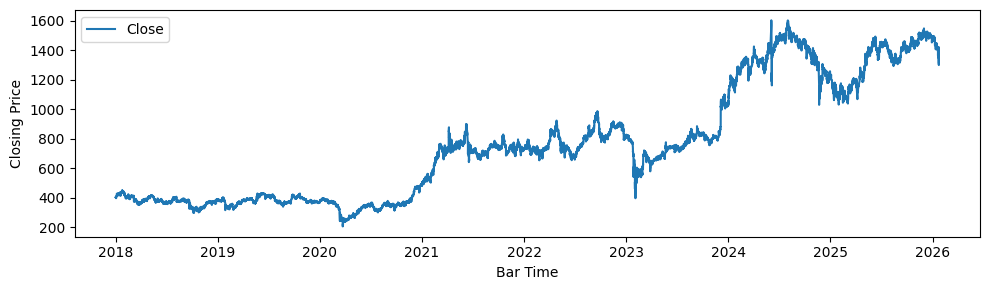

In [8]:
fig, ax = plt.subplots(figsize=(10, 3))

ax.plot(df["close"], label="Close")

ax.set_xlabel("Bar Time")
ax.set_ylabel("Closing Price")

plt.legend()
plt.tight_layout()
plt.show()


In [9]:
df["resistance"] = df["close"].shift().rolling(10).max()
df["support"]    = df["close"].shift().rolling(10).min()

df= df.dropna(how="any")


In [10]:
df[["close","support","resistance"]].head()

,close,support,resistance
datetime,,,
2018-01-01 10:10:00+05:30,404.00,403.55,404.9
2018-01-01 10:15:00+05:30,404.25,403.55,404.9
2018-01-01 10:20:00+05:30,404.60,403.55,404.9
2018-01-01 10:25:00+05:30,404.90,403.55,404.9
2018-01-01 10:30:00+05:30,404.25,403.80,404.9


In [11]:
# plot_ohlc_with_sr(df.tail(75))

In [12]:
df[["close", "high", "low", "support", "resistance"]].head()

,close,high,low,support,resistance
datetime,,,,,
2018-01-01 10:10:00+05:30,404.00,404.8,404.00,403.55,404.9
2018-01-01 10:15:00+05:30,404.25,404.3,403.85,403.55,404.9
2018-01-01 10:20:00+05:30,404.60,404.6,404.05,403.55,404.9
2018-01-01 10:25:00+05:30,404.90,405.4,404.60,403.55,404.9
2018-01-01 10:30:00+05:30,404.25,405.0,404.20,403.80,404.9


    ATR implementation for stop loss

In [13]:
# Calculate True Range (Wilder's definition)
df['prev_close'] = df['close'].shift(1)
df['tr'] = df[['high', 'low', 'prev_close']].apply(
    lambda x: max(x['high'] - x['low'], 
                      abs(x['high'] - x['prev_close']), 
                                        abs(x['low'] - x['prev_close'])), axis=1
                                        )
df['atr'] = df['tr'].shift().rolling(14).mean()

#### Indicators as filter

In [14]:
# Calculate RSI (14-period standard)
def calculate_rsi(data, period=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Add RSI
df['rsi'] = calculate_rsi(df['close'], period=14).shift()  # shift to avoid lookahead


#### Creating Strategy

    Adding a trend filter.

In [15]:
# Add simple trend filter
df['sma_50'] = df['close'].shift().rolling(50).mean()
df['sma_200'] = df['close'].shift().rolling(200).mean()
df["sma_20"] = df["close"].shift().rolling(20).mean() 

# Uptrend: price > SMA50 > SMA200
df['uptrend'] = (
                 (df['sma_50'] > df['sma_200']) &
                 (df["close"]>df["sma_20"])
                 ).astype(int)

df["downtrend"] = ( 
                 (df['sma_50']< df['sma_200']) &
                 (df["close"]<df["sma_20"])
                 ).astype(int)


    Calculating Entry Signal 

In [16]:
df['entry_signal'] = (
    (df['low'] <= df['support']) &
    (df['rsi'] > 35) &
    (df['rsi'] < 55) &
    (df['uptrend'] == 1)
).astype(int)


    Calculating Entry Price

In [17]:
df["entry_price"] = np.where(df["entry_signal"]==1, df["support"], np.nan)

    Calculating Exit conditions

In [18]:
df["target_price"] = np.where(df["entry_signal"]==1, df["resistance"], np.nan )

df["stop_loss_price"] = np.where(df["entry_signal"]==1, df["entry_price"]-(1 * df["atr"]), np.nan)

#### Creating positions

    Initializing variables

#### Creating Long Positions

In [19]:
#INitializing trade pnl logic
df["trade_pnl"] = 0.0
df["exit_reason"] = ''
df["in_position"] = 0
trade_pnls = []
starting_capital = df.iloc[0]['close']
# starting_capital = 10000


entry_price = np.nan
stop_price = np.nan
target_price = np.nan
in_trade = False
TRANSACTION_COST = 0.0002

#For machine Learning
entry_index = None
df["ml_target"] =  np.nan
df["holding_period"] = np.nan

In [20]:
for i in range(len(df)):
    idx = df.index[i]

    #Mark if we are in position in this bar

    df.loc[idx, "in_position"] = 1 if  in_trade else 0


    #Exit logic first

    if in_trade:
        current_low = df.loc[idx, "low"]
        current_high = df.loc[idx, "high"]

        #Exit conditions
        if current_low<= stop_price:
            exit_price = stop_price
            exit_reason = "STOP" 
        elif current_high >= target_price:
            exit_price = target_price
            exit_reason = "TARGET"
        else:
            exit_price = None
        #Calculating PNL
        if exit_price is not None:
            pnl_per_share_gross = exit_price - entry_price
            
            #Calculating transaction cost
            cost_entry_per_share = entry_price * TRANSACTION_COST
            cost_exit_per_share = exit_price * TRANSACTION_COST
            total_cost_per_share = cost_entry_per_share + cost_exit_per_share

            pnl_per_share_net = pnl_per_share_gross - total_cost_per_share

            #Calculate position size
            # position_value = starting_capital
            # shares = position_value/entry_price
            shares = 1

            #Total pnl for the position
            pnl_total_gross = pnl_per_share_gross * shares
            total_cost_total = total_cost_per_share * shares
            pnl_total_net = pnl_per_share_net * shares

            trade_pnls.append(pnl_total_net)

            # Assign to dataframe at exit bar

            df.loc[idx, 'trade_pnl'] =  pnl_total_net
            df.loc[idx, 'exit_reason'] = exit_reason
            # Use percentage return (comparable across stocks):
            df.loc[entry_index, 'ml_target'] = (pnl_per_share_net / entry_price) * 100
            df.loc[entry_index, "holding_period"] = i - df.index.get_loc(entry_index)


            #Reset state

            in_trade = False
            entry_price = np.nan
            stop_price = np.nan
            target_price = np.nan
    
    #Entry logic
    elif df.loc[idx, "entry_signal"] == 1:
        in_trade = True
        entry_price = df.loc[idx, "entry_price"]
        stop_price = df.loc[idx, "stop_loss_price"]
        target_price = df.loc[idx, "target_price"]

        entry_index = idx

 

In [21]:
np.sum(trade_pnls)

np.float64(992.4489949999981)

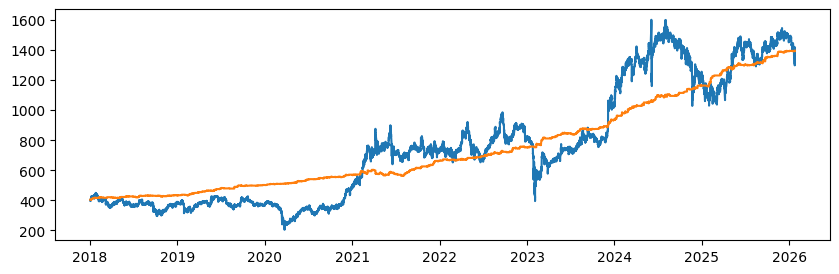

In [22]:
df["cumulative_pnl"] = df["trade_pnl"].cumsum()
df["equity_curve"] = starting_capital + df["cumulative_pnl"]

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(df["close"])
ax.plot(df["equity_curve"])

In [23]:
df['ml_target'].values

array([nan, nan, nan, ..., nan, nan, nan], shape=(149238,))

In [24]:
df['ml_target'].notna().sum()

np.int64(1125)

In [25]:
df['ml_target'].isna().sum()

np.int64(148113)

In [26]:
# Add this right after your loop
print(f"\nTotal trades executed: {len(trade_pnls)}")
print(f"ML targets stored: {df['ml_target'].notna().sum()}")
print(f"Entry signals: {(df['entry_signal'] == 1).sum()}")


Total trades executed: 1125
ML targets stored: 1125
Entry signals: 1409


#### Adding shorting opportunities

In [27]:
df['entry_signal_short'] = (
    (df['high'] >= df['resistance']) &
    (df['rsi'] > 50) &  # Price showing strength/overbought
    (df['rsi'] < 70)   # But not extremely overbought
    & (df['downtrend'] == 1)
).astype(int)

In [28]:
# Entry at close when price touches resistance
df["entry_price_short"] = np.where(df["entry_signal_short"]==1, 
                                    df["resistance"], 
                                    np.nan)

In [29]:

df["target_price_short"] = np.where(df["entry_signal_short"]==1, 
                                    df["support"],  # or df["close"] - (2 * df["atr"])
                                    np.nan)

# Stop ABOVE entry (correct - you have this right!)
df["stop_loss_price_short"] = np.where(df["entry_signal_short"]==1, 
                                       df["entry_price_short"] + (1 * df["atr"]), 
                                       np.nan)

In [30]:
# Initializing trade pnl logic for SHORTS
df["trade_pnl_short"] = 0.0
df["exit_reason_short"] = ''
df["in_position_short"] = 0
trade_pnls_short = []
starting_capital_short = df.iloc[0]['close']
# starting_capital_short = 10000

entry_price_short = np.nan
stop_price_short = np.nan
target_price_short = np.nan
in_trade_short = False
TRANSACTION_COST_SHORT = 0.0002  # Consider if shorts have higher costs

# For machine learning
entry_index_short = None
df["ml_target_short"] = np.nan
df["holding_period_short"] = np.nan

In [31]:
for i in range(len(df)):
    idx = df.index[i]

    # Mark if we are in position in this bar
    df.loc[idx, "in_position_short"] = 1 if in_trade_short else 0

    # Exit logic first
    if in_trade_short:
        current_low = df.loc[idx, "low"]
        current_high = df.loc[idx, "high"]

        # Exit conditions (INVERTED for shorts)
        if current_high >= stop_price_short:  # Stop hit when price goes UP
            exit_price = stop_price_short
            exit_reason = "STOP" 
        elif current_low <= target_price_short:  # Target hit when price goes DOWN
            exit_price = target_price_short
            exit_reason = "TARGET"
        else:
            exit_price = None
            
        # Calculating PNL
        if exit_price is not None:
            # INVERTED: profit when exit < entry for shorts
            pnl_per_share_gross = entry_price_short - exit_price  
            
            # Calculating transaction cost
            cost_entry_per_share = entry_price_short * TRANSACTION_COST_SHORT
            cost_exit_per_share = exit_price * TRANSACTION_COST_SHORT
            total_cost_per_share = cost_entry_per_share + cost_exit_per_share

            pnl_per_share_net = pnl_per_share_gross - total_cost_per_share

            # Calculate position size
            # position_value = starting_capital_short
            # shares = position_value / entry_price_short
            shares = 1

            # Total pnl for the position
            pnl_total_gross = pnl_per_share_gross * shares
            total_cost_total = total_cost_per_share * shares
            pnl_total_net = pnl_per_share_net * shares

            trade_pnls_short.append(pnl_total_net)

            # Assign to dataframe at exit bar
            df.loc[idx, 'trade_pnl_short'] = pnl_total_net
            df.loc[idx, 'exit_reason_short'] = exit_reason
            
            # Use percentage return (comparable across stocks):
            df.loc[entry_index_short, 'ml_target_short'] = (pnl_per_share_net / entry_price_short) * 100
            df.loc[entry_index_short, "holding_period_short"] = i - df.index.get_loc(entry_index_short)

            # Reset state
            in_trade_short = False
            entry_price_short = np.nan
            stop_price_short = np.nan
            target_price_short = np.nan
    
    # Entry logic
    elif (df.loc[idx, "entry_signal_short"] == 1) and (not in_trade_short):

        in_trade_short = True
        entry_price_short = df.loc[idx, "entry_price_short"]
        stop_price_short = df.loc[idx, "stop_loss_price_short"]
        target_price_short = df.loc[idx, "target_price_short"]
        
        entry_index_short = idx

In [32]:
df["ml_target_short"].notna().sum()

np.int64(615)

In [33]:
df["ml_target_short"].isna().sum()

np.int64(148623)

In [34]:
np.sum(trade_pnls_short)

np.float64(772.3906728571415)

In [35]:
df["trade_pnl_total"] = df["trade_pnl"] + df["trade_pnl_short"]


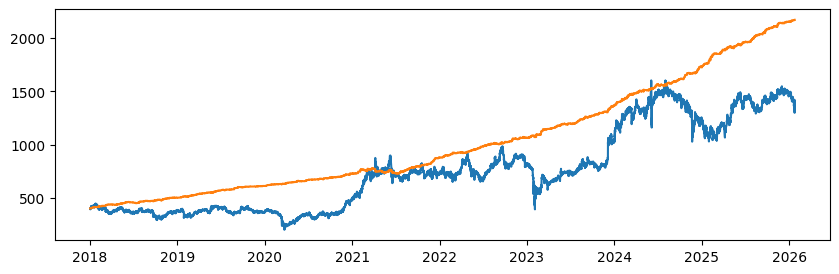

In [36]:
df["cumulative_pnl"] = df["trade_pnl_total"].cumsum()
df["equity_curve"] = starting_capital + df["cumulative_pnl"]

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(df["close"])
ax.plot(df["equity_curve"])

#### Year On Year Results

In [37]:
# df['year'] = df.index.year

# # Group by year and calculate metrics
# def calculate_year_metrics(group):
#     # Equity metrics
#     start_equity = group['equity_curve'].iloc[0]
#     end_equity = group['equity_curve'].iloc[-1]
#     year_return = (end_equity - start_equity) / start_equity * 100
    
#     # Drawdown
#     running_max = group['equity_curve'].cummax()
#     drawdown = (group['equity_curve'] - running_max) / running_max * 100
#     max_drawdown = drawdown.min()
    
#     # Trade metrics
#     trades = group[group['trade_pnl_total'] != 0]
#     num_trades = len(trades)
#     winning_trades = len(trades[trades['trade_pnl_total'] > 0])
#     losing_trades = len(trades[trades['trade_pnl_total'] < 0])
#     win_rate = (winning_trades / num_trades * 100) if num_trades > 0 else 0
    
#     # Average win/loss
#     avg_win = trades[trades['trade_pnl_total'] > 0]['trade_pnl_total'].mean() if winning_trades > 0 else 0
#     avg_loss = trades[trades['trade_pnl_total'] < 0]['trade_pnl_total'].mean() if losing_trades > 0 else 0
    
#     # Sharpe ratio
#     daily_returns = group['equity_curve'].pct_change().dropna()
#     sharpe = np.sqrt(252) * daily_returns.mean() / daily_returns.std() if len(daily_returns) > 1 and daily_returns.std() > 0 else 0
    
#     return pd.Series({
#         'Start Equity': start_equity,
#         'End Equity': end_equity,
#         'Total Return (%)': year_return,
#         'Max Drawdown (%)': max_drawdown,
#         'Trades': num_trades,
#         'Win Rate (%)': win_rate,
#         'Avg Win': avg_win,
#         'Avg Loss': avg_loss,
#         'Sharpe Ratio': sharpe
#     })

# # Apply to all years at once
# yearly_df = df.groupby('year').apply(calculate_year_metrics).reset_index()

# # Calculate overall CAGR
# first_equity = df['equity_curve'].iloc[0]
# last_equity = df['equity_curve'].iloc[-1]
# years_total = (df.index[-1] - df.index[0]).days / 365.25
# cagr = ((last_equity / first_equity) ** (1 / years_total) - 1) * 100

# # Overall max drawdown
# running_max_all = df['equity_curve'].cummax()
# drawdown_all = (df['equity_curve'] - running_max_all) / running_max_all * 100
# max_dd_all = drawdown_all.min()

# print("=" * 80)
# print("YEAR-ON-YEAR PERFORMANCE")
# print("=" * 80)
# print(yearly_df.to_string(index=False))
# print("\n" + "=" * 80)
# print("OVERALL METRICS")
# print("=" * 80)
# print(f"Starting Capital: ₹{first_equity:,.2f}")
# print(f"Ending Capital: ₹{last_equity:,.2f}")
# print(f"Total Return: {((last_equity/first_equity - 1) * 100):.2f}%")
# print(f"CAGR: {cagr:.2f}%")
# print(f"Max Drawdown: {max_dd_all:.2f}%")
# print(f"Total Period: {years_total:.2f} years")
# print("=" * 80)

# # Same visualizations as before
# fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# axes[0, 0].bar(yearly_df['year'], yearly_df['Total Return (%)'], 
#                color=['green' if x > 0 else 'red' for x in yearly_df['Total Return (%)']])
# axes[0, 0].set_title('Annual Returns (%)')
# axes[0, 0].set_xlabel('Year')
# axes[0, 0].set_ylabel('Return (%)')
# axes[0, 0].grid(axis='y', alpha=0.3)
# axes[0, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# axes[0, 1].bar(yearly_df['year'], yearly_df['Max Drawdown (%)'], color='red', alpha=0.6)
# axes[0, 1].set_title('Maximum Drawdown by Year (%)')
# axes[0, 1].set_xlabel('Year')
# axes[0, 1].set_ylabel('Drawdown (%)')
# axes[0, 1].grid(axis='y', alpha=0.3)

# axes[1, 0].bar(yearly_df['year'], yearly_df['Trades'], color='blue', alpha=0.6)
# axes[1, 0].set_title('Number of Trades by Year')
# axes[1, 0].set_xlabel('Year')
# axes[1, 0].set_ylabel('Trades')
# axes[1, 0].grid(axis='y', alpha=0.3)

# axes[1, 1].plot(df.index, df['equity_curve'], linewidth=1.5)
# axes[1, 1].set_title('Equity Curve')
# axes[1, 1].set_xlabel('Date')
# axes[1, 1].set_ylabel('Equity')
# axes[1, 1].grid(alpha=0.3)

# for year in yearly_df['year'].unique():
#     year_start = df[df['year'] == year].index[0]
#     axes[1, 1].axvline(x=year_start, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)

# plt.tight_layout()
# plt.show()

# yearly_df

In [38]:
# # Then in the save section:
# results = {
#     'metadata': {
#         'filename': filename,
#         'timeframe': timeframe,
#         'timestamp': datetime.now().isoformat(),
#         'total_period_years': years_total,
#         'starting_capital': first_equity,
#         'ending_capital': last_equity,
#         'total_return_pct': ((last_equity/first_equity - 1) * 100),
#         'cagr_pct': cagr,
#         'max_drawdown_pct': max_dd_all
#     },
#     'yearly_performance': yearly_df.to_dict(orient='records')
# }

# key = f"{filename}_{timeframe}"

# json_filepath = '../research_consolidation/results_json/results_json.json'

# if os.path.exists(json_filepath):
#     with open(json_filepath, 'r') as f:
#         all_results = json.load(f)
# else:
#     all_results = {}

# all_results[key] = results

# with open(json_filepath, 'w') as f:
#     json.dump(all_results, f, indent=2)

# print(f"✓ Results saved with key: {key}")
# print(f"✓ Total runs in file: {len(all_results)}")

#### Sanity Check

In [39]:
required_columns = ['open', 'high', 'low', 'close', 'volume', 'resistance', 'support','atr', 'rsi', 'sma_50', 'sma_200', 'sma_20','uptrend','ml_target', 'ml_target_short']
df = df[required_columns]
df.head()

,open,high,low,close,volume,resistance,support,atr,rsi,sma_50,sma_200,sma_20,uptrend,ml_target,ml_target_short
datetime,,,,,,,,,,,,,,,
2018-01-01 10:10:00+05:30,404.80,404.8,404.00,404.00,5506,404.9,403.55,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2018-01-01 10:15:00+05:30,404.00,404.3,403.85,404.25,1951,404.9,403.55,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2018-01-01 10:20:00+05:30,404.35,404.6,404.05,404.60,2360,404.9,403.55,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2018-01-01 10:25:00+05:30,404.60,405.4,404.60,404.90,8799,404.9,403.55,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2018-01-01 10:30:00+05:30,404.90,405.0,404.20,404.25,7780,404.9,403.80,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


In [40]:
# required_columns = ['open', 'high', 'low', 'close', 'volume', 'resistance', 'support','atr', 'rsi', 'sma_50', 'sma_200', 'sma_20','uptrend','downtrend']
# df = df[required_columns]
# df.head()

In [41]:
df.to_csv(f"./raw_data_for_machine_learning/{filename}.csv", index='datetime')

In [42]:
df["ml_target"].notna().sum()

np.int64(1125)

In [43]:
df["ml_target"].value_counts()

ml_target
 0.276238    2
 0.077762    2
 0.040138    2
 0.047911    2
 0.058868    2
            ..
 0.189049    1
-0.135438    1
 0.095108    1
-0.160400    1
 0.278746    1
Name: count, Length: 1116, dtype: int64

In [44]:
df["ml_target_short"].notna().sum()

np.int64(615)

In [45]:
df["ml_target_short"].value_counts()

ml_target_short
 0.047386    2
 0.316993    2
 0.439348    1
 0.424017    1
-0.332405    1
            ..
 0.230507    1
-0.148417    1
 0.558387    1
 0.211746    1
 0.261942    1
Name: count, Length: 613, dtype: int64

In [46]:
df[df["ml_target_short"] == 1]["ml_target_short"]

Series([], Name: ml_target_short, dtype: float64)